# MQ-9

## Ro calculation

### Specifications

#### Standard Work Condition

    Vc    (Circuit Voltage)        :  5v +/- 0.1
    VH(h) (Heating Voltage - high) :  5v +/- 0.1
    VH(l) (Heating Voltage - low)  :  1.4v +/- 0.1
    RL    (Load Resistance)        :  can adjust
    RH    (Heater Resistance)      :  33 Ohm +/- 5%
    TH(H) (Heating time (high)     :  60 +/- 1 seconds
    TH(L) (Heating time (low)      :  90 +/- 1 seconds
    PH    (Heating consumption)    :  less than 340 mW
    

#### Sensitivity Characteristic:

    Rs (Sensing Resistance)    : 2kOhm  -  20kOhm (100ppm Carbon Monoxide)
    Preheat Time               : No less than 48 hours
    
    Detecting range:
        Carbon Monoxide :  20ppm  - 2000ppm 
        CH4             :  500ppm - 10000ppm 
        LPG             :  500ppm - 10000ppm 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
## Gas concentration values referenced in the datasheet
POINTS = {
    # Liquefied Petroleum Gas
    'lpg' : {
        'p1' : {'x': 50,   'y': 2.092},
        'p2' : {'x': 500,  'y': 1.361},
        'p3' : {'x': 800,  'y': 1.108},
        'p4' : {'x': 1000, 'y': 1.000},
        'p5' : {'x': 1500, 'y': 0.824},
        'p6' : {'x': 2000, 'y': 0.726},
        'p7' : {'x': 3000, 'y': 0.594},
        'p8' : {'x': 5000, 'y': 0.464},
        'p8' : {'x': 10000,'y': 0.332}
    },

    # Carbon Monoxide
    'co' : {
        'p1' : {'x': 50,   'y': 1.631},
        'p2' : {'x': 500,  'y': 1.068},
        'p3' : {'x': 800,  'y': 0.869},
        'p4' : {'x': 1000, 'y': 0.785}
    },

    # Methane
    'ch4' : {
        'p1' : {'x': 50,   'y': 3.122},
        'p2' : {'x': 500,  'y': 2.294},
        'p3' : {'x': 800,  'y': 1.913},
        'p4' : {'x': 1000, 'y': 1.769},
        'p5' : {'x': 1500, 'y': 1.539},
        'p6' : {'x': 2000, 'y': 1.372},
        'p7' : {'x': 3000, 'y': 1.173},
        'p8' : {'x': 5000, 'y': 0.949},
        'p8' : {'x': 10000,'y': 0.701}
    }  
}



AIR = 9.774

GASES = ['lpg', 'co', 'ch4']

In [3]:
# RS value calculation
Rs    = lambda Vcc, Vrl, RL : ((Vcc * RL) / Vrl) - RL

# R0 value calculation
R0    = lambda Rs, air : Rs / air

# RS/Ro value calculation (ratio)
Ratio = lambda Rs, R0: Rs / R0

# log(y) = m.log(x) + b
# m
M     = lambda p1, p2 : (math.log10( p2['y'] / p1['y'] )) / (math.log10(p2['x']/p1['x']))
# b
B     = lambda p, m : math.log10(p['y']) - (m * math.log10(p['x']))

# PPM value calculation 
PPM   = lambda  y, m, b: 10 ** ((math.log10(y) - b) / m)

In [4]:
## Calculate the points to be used for the calculation of _m_ and _b_ according to the _ratio_ value 
def getPoints(racio, values):
    size = len(values)
    for idx in range(size - 1):
        if racio >= values[idx]['y']:
            if idx == 0:
                return (values[0], values[1])
            return(values[idx - 1], values[idx])
    return(values[size - 2], values[size - 1])

In [5]:
pList = {}
for gas in GASES:
    pList[gas] = list(POINTS[gas].values())

In [6]:
col_list = ["date", "mq9_1", "mq9_2"]
df = pd.read_csv('EmptyRoom_9-14Jun.csv', usecols=col_list)

df['date']= pd.to_datetime(df['date'])

mq9_1 = df[["date","mq9_1"]]
mq9_2 = df[["date","mq9_2"]]

### Ro values to be considered

- __Sensor 1__: 84.24 kOhms
- __Sensor 2__: 19.44 kOhms

In [7]:
# MQ 9 - sensor 1
sensor1 = {}
sensor1['Vcc'] = 5      #volts
sensor1['RL']  = 10     #kOhms
sensor1['AIR'] = AIR   
sensor1['Ro']  = 84.24  #kOhms


# MQ 9 - sensor 2
sensor2 = {}
sensor2['Vcc'] = 5      #volts
sensor2['RL']  = 10     #kOhms
sensor2['AIR'] = AIR   
sensor2['Ro']  = 84.24  #kOhms


In [8]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq9_1['mq9_1'].min(),
    mq9_1['mq9_1'].mean(), 
    mq9_1['mq9_1'].quantile(0.25),
    mq9_1['mq9_1'].quantile(0.5),
    mq9_1['mq9_1'].quantile(0.75),
    mq9_1['mq9_1'].max()]

sensor1['Rs'] = [Rs(sensor1['Vcc'] , v, sensor1['RL'] ) for v in Vrl]
sensor1['Ratio'] = [Ratio(rs, sensor1['Ro']) for rs in sensor1['Rs']]


ppm1 = {}
for gas in GASES:
    ppm1[gas] = []

for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm1[gas].append(PPM(r, m, b))
    

In [9]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq9_2['mq9_2'].min(),
    mq9_2['mq9_2'].mean(), 
    mq9_2['mq9_2'].quantile(0.25),
    mq9_2['mq9_2'].quantile(0.5),
    mq9_2['mq9_2'].quantile(0.75),
    mq9_2['mq9_2'].max()]

sensor2['Rs'] = [Rs(sensor2['Vcc'] , v, sensor2['RL'] ) for v in Vrl]
sensor2['Ratio'] = [Ratio(rs, sensor2['Ro']) for rs in sensor2['Rs']]

ppm2 = {}
for gas in GASES:
    ppm2[gas] = []

for r in sensor2['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm2[gas].append(PPM(r, m, b))
    

In [10]:
print(f"Period in which the readings were carried out: {mq9_1['date'].min()} - {mq9_1['date'].max()} \n")

print("Sensor 1")


print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('', 'Min', 'Mean', '1Q', '2Q', '3Q', 'Max'))

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('Rs/Ro', 
               round(sensor1['Ratio'][0],3),
               round(sensor1['Ratio'][1],3),
               round(sensor1['Ratio'][2],3),
               round(sensor1['Ratio'][3],3),
               round(sensor1['Ratio'][4],3),
               round(sensor1['Ratio'][5],3)))

for gas in GASES:
    print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
           .format(gas.upper(), 
                   round(ppm1[gas][0],3),
                   round(ppm1[gas][1],3),
                   round(ppm1[gas][2],3),
                   round(ppm1[gas][3],3),
                   round(ppm1[gas][4],3),
                   round(ppm1[gas][5],3)))
    
print("-"*(12*7))
    
print("Sensor 2")

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('', 'Min', 'Mean', '1Q', '2Q', '3Q', 'Max'))

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('Rs/Ro', 
               round(sensor2['Ratio'][0],3),
               round(sensor2['Ratio'][1],3),
               round(sensor2['Ratio'][2],3),
               round(sensor2['Ratio'][3],3),
               round(sensor2['Ratio'][4],3),
               round(sensor2['Ratio'][5],3)))

for gas in GASES:
    print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
           .format(gas.upper(), 
                   round(ppm2[gas][0],3),
                   round(ppm2[gas][1],3),
                   round(ppm2[gas][2],3),
                   round(ppm2[gas][3],3),
                   round(ppm2[gas][4],3),
                   round(ppm2[gas][5],3)))

Period in which the readings were carried out: 2022-06-09 20:27:00 - 2022-06-14 09:08:00 

Sensor 1
             Min          Mean         1Q           2Q           3Q           Max         
Rs/Ro        9.774        9.475        9.774        9.774        9.774        6.476       
LPG          0.013        0.015        0.013        0.013        0.013        0.118       
CO           0.003        0.003        0.003        0.003        0.003        0.028       
CH4          0.01         0.012        0.01         0.01         0.01         0.214       
------------------------------------------------------------------------------------
Sensor 2
             Min          Mean         1Q           2Q           3Q           Max         
Rs/Ro        2.255        1.969        2.164        2.001        1.86         1.23        
LPG          33.417       69.135       41.697       63.434       93.904       629.816     
CO           8.578        17.945       10.739       16.443       24.489       

In [11]:
font = {
    'family': 'serif',
    'color':  'tab:red',
    'weight': 'normal',
    'size': 14
}

font_title = {
    'family': 'serif',
    'color':  'tab:blue',
    'weight': 'normal',
    'size': 16,
}

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray','tab:olive','tab:cyan']

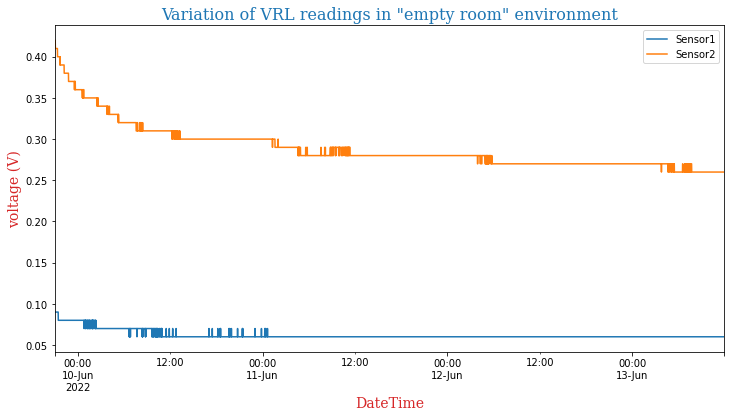

In [12]:
fdf = df[(df['date'] > '6/9/22 9:00 PM') & (df['date'] < '6/13/22 12:00 PM')]

ax = fdf.plot(x='date', y=["mq9_1","mq9_2"], 
              kind="line", figsize=(12, 6))

plt.title('Variation of VRL readings in "empty room" environment', fontdict=font_title)
plt.xlabel('DateTime',    fontdict=font)
plt.ylabel('voltage (V)', fontdict=font)
plt.legend(['Sensor1', 'Sensor2'], loc='best')


plt.show()

In [13]:
# MQ 9 Sensor1

sensor1['Rs'] = [Rs(sensor1['Vcc'] , v, sensor1['RL'] ) for v in mq9_1["mq9_1"]]
sensor1['Ratio'] = [Ratio(rs, sensor1['Ro']) for rs in sensor1['Rs']]

ppm1 = {}
for gas in GASES:
    ppm1[gas] = []
    
for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm1[gas].append(PPM(r, m, b))

for gas in GASES:
    mq9_1[gas] = ppm1[gas]

In [14]:
# MQ 9 Sensor 2

sensor2['Rs'] = [Rs(sensor2['Vcc'] , v, sensor2['RL'] ) for v in mq9_2["mq9_2"]]
sensor2['Ratio'] = [Ratio(rs, sensor2['Ro']) for rs in sensor2['Rs']]

ppm2 = {}
for gas in GASES:
    ppm2[gas] = []
    
for r in sensor2['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm2[gas].append(PPM(r, m, b))

for gas in GASES:
    mq9_2[gas] = ppm2[gas]

In [15]:
mq9_1.describe()

,mq9_1,lpg,co,ch4
count,6522.000000,6522.000000,6522.000000,6522.000000
mean,0.061866,0.017242,0.003952,0.016642
std,0.005364,0.014225,0.003347,0.024989
min,0.060000,0.012975,0.002952,0.009905
25%,0.060000,0.012975,0.002952,0.009905
50%,0.060000,0.012975,0.002952,0.009905
75%,0.060000,0.012975,0.002952,0.009905
max,0.090000,0.117604,0.027681,0.214437


In [16]:
mq9_2.describe()

,mq9_2,lpg,co,ch4
count,6522.000000,6522.000000,6522.000000,6522.000000
mean,0.284278,81.810595,21.647997,772.169793
std,0.029371,75.693215,22.309980,282.837240
min,0.250000,33.417014,8.577610,522.409811
25%,0.260000,41.696721,10.739283,581.377679
50%,0.280000,63.433897,16.443343,712.028296
75%,0.300000,93.904049,24.488743,867.038704
max,0.440000,629.815702,231.706832,2651.991136


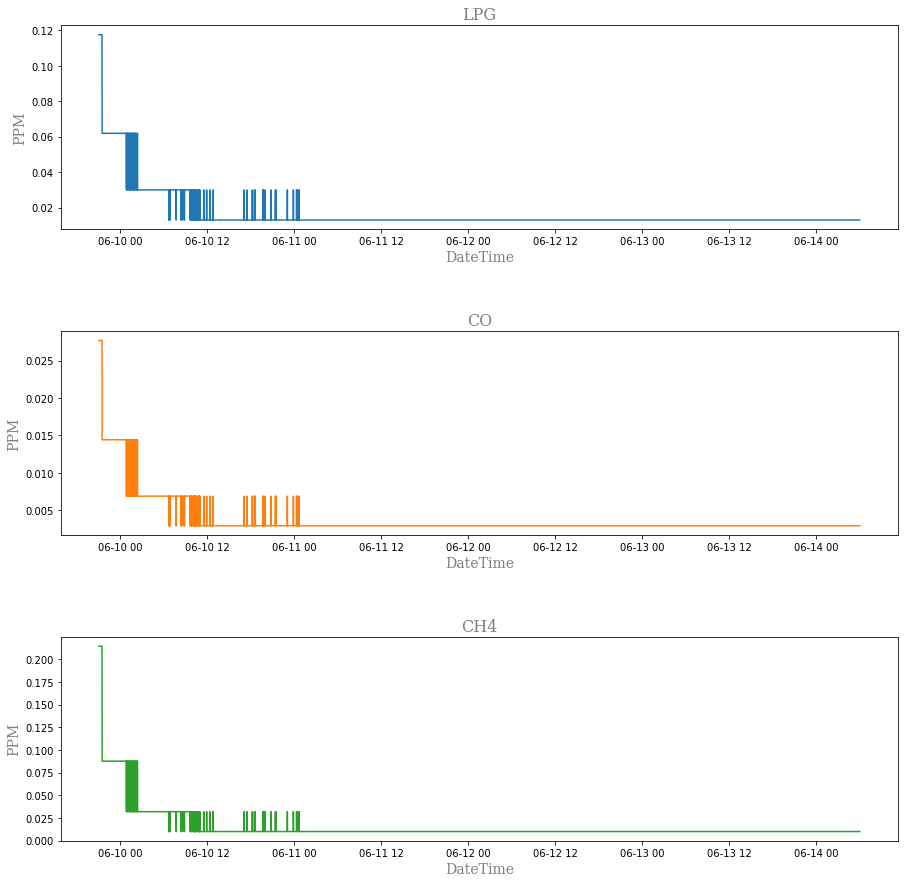

In [17]:
# Time Interval:
#           min: 2022-06-09 20:27:00
#           max: 2022-06-14 09:08:00 

fmq = mq9_1[(mq9_1['date'] > '6/9/22 9:00 PM') & (mq9_1['date'] < '6/14/22 06:00 AM')]

plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace = 0.5)

for idx in range(len(GASES)):
    plt.subplot(len(GASES) * 100 + 11 + idx)
    plt.plot(fmq['date']         , fmq[GASES[idx]],        color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    


plt.show()

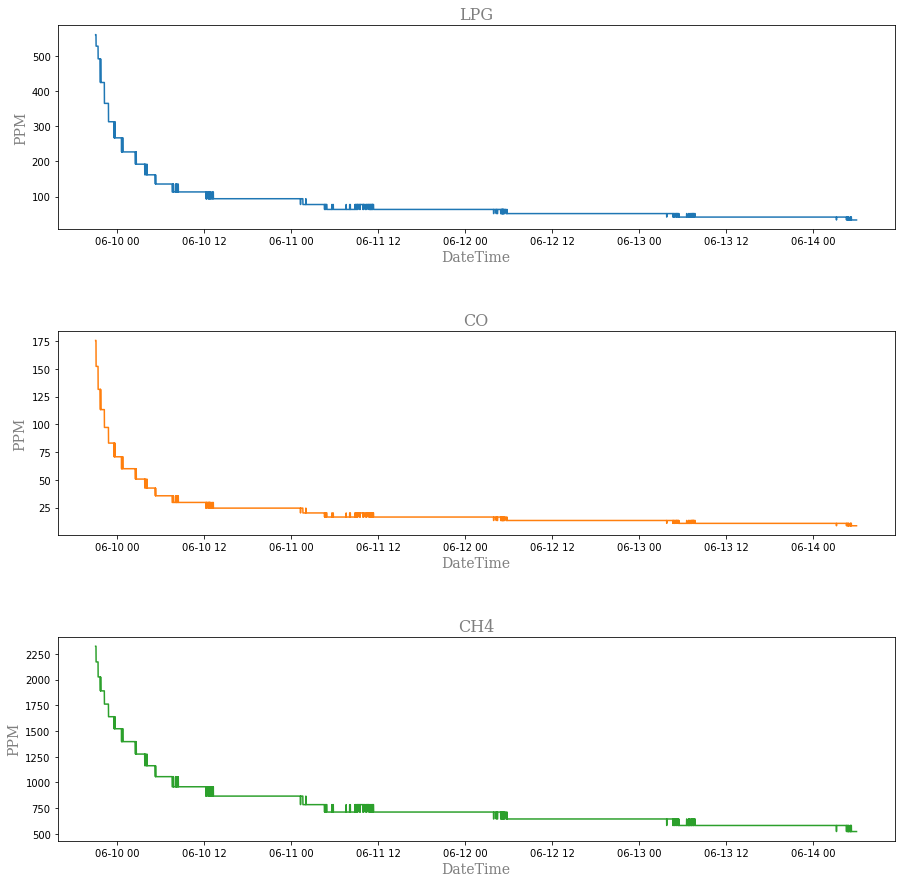

In [18]:
# Time Interval:
#           min: 2022-06-09 20:27:00
#           max: 2022-06-14 09:08:00 

fmq = mq9_2[(mq9_2['date'] > '6/9/22 9:00 PM') & (mq9_2['date'] < '6/14/22 06:00 AM')]

plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace = 0.5)

for idx in range(len(GASES)):
    plt.subplot(len(GASES) * 100 + 11 + idx)
    plt.plot(fmq['date']         , fmq[GASES[idx]],        color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    


plt.show()

In [19]:
# Save in excel file
mq9_1.to_csv('mq9_1_in_empty_room.csv')
mq9_2.to_csv('mq9_2_in_empty_room.csv')